In [344]:
import os, glob, json 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import sys 
sys.path.append('./helper')

In [345]:
# point the example data 
sub_name = 'sub374'
task_name = 'walking+nomemory'
data_dir = glob.glob(f'/mnt/HDD/jiwon/2024_spring_pilot/{sub_name}/{sub_name}_{task_name}_*')[0]



### Calibrate gaze points

In [346]:
# load transformation parameters and transform data 
import skimage.transform as tf

saving_dir = data_dir + '/gaze_calibrated.csv'
# if the gaze_calibrated.csv is existing, skip this part 
if not os.path.exists(saving_dir): 
    params_dir = os.path.dirname(data_dir) + '/gaze_calibration_params.json'
    with open(params_dir, 'r') as file:
        params = json.load(file)

    gazes = pd.read_csv(data_dir + '/gaze.csv')

    # convert gazes in visual angle 
    matrix_deg = tf.AffineTransform(matrix = params['tf_matrix_deg'])
    transformed = matrix_deg(gazes[['azimuth [deg]', 'elevation [deg]']].values)
    gazes['gaze x [deg]'] = transformed[:,0]
    gazes['gaze y [deg]'] = transformed[:,1]

    # drop azimuth and elevation 
    gazes.drop(columns = ['azimuth [deg]', 'elevation [deg]'], inplace=True)

    # convert gazes in px 
    matrix_px = tf.AffineTransform(matrix = params['tf_matrix_px'])
    transformed = matrix_px(gazes[['gaze x [px]', 'gaze y [px]']].values)
    gazes['gaze x [px]'] = transformed[:,0]
    gazes['gaze y [px]'] = transformed[:,1]

    # save gazes 
    gazes.to_csv(saving_dir)

else:
    print(f'{os.path.basename(saving_dir)} is existing already. Load the data...')
    gazes = pd.read_csv(saving_dir)


### Using saccade labels, compute duration, amplitude and peak velocity

In [347]:
# import saccade information 
# saccade information already exclude fixations and blinks 
saccade = pd.read_csv(data_dir + '/saccades.csv')
amplitude = []      # deg
peak_velocity = []  # deg/s
duration = []       # ms
for s_id in range(len(saccade)): 
    # get times 
    start_time = saccade['start timestamp [ns]'].loc[s_id]
    end_time = saccade['end timestamp [ns]'].loc[s_id]

    # select gazes 
    gaze_points = gazes.loc[(gazes['timestamp [ns]'] >= start_time) & (gazes['timestamp [ns]'] <= end_time)] 
    one_fifth = round(len(gaze_points)/5)


    # compute amplitude 
    amp = np.linalg.norm(gaze_points.iloc[:one_fifth][['gaze x [deg]', 'gaze y [deg]']].median().values - gaze_points.iloc[-one_fifth:][['gaze x [deg]', 'gaze y [deg]']].median().values)
    amplitude.append(amp)
        
    # velocity 
    vel = np.linalg.norm(np.diff(gaze_points[['gaze x [deg]', 'gaze y [deg]']], axis=0), axis=1) / (np.diff(gaze_points['timestamp [ns]'])/1e9)  # deg / s
    peak_velocity.append(max(vel))

    # duration 
    duration.append((end_time-start_time)/1e6)   # in ms
    
    

### Perform main_sequence fitting

In [348]:
import main_sequence_filter as ms
import custom_figure as cf

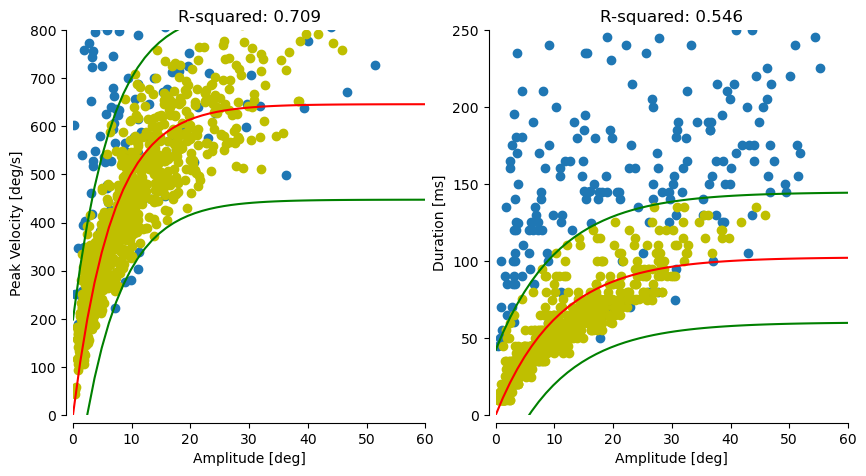

In [349]:
# do the filtering
filter = ms.saccade_filter()
filter_res = filter.fitting(amplitude = amplitude, peak_velocity = peak_velocity, duration=duration, p0 = [400, 200])

# draw the figure 
fig, ax = plt.subplots(1,2,figsize=(10,5))
filter.draw_figure('amp_vel_res', ax=ax[0])
cf.xy_axis_format(ax[0])
filter.draw_figure('amp_dur_res', ax=ax[1], y_max=250)
cf.xy_axis_format(ax[1])

if not os.path.exists(f'./figure/{sub_name}'):
    os.mkdir(f'./figure/{sub_name}')
fig_name = f'./figure/{sub_name}/main_sequence_{task_name}.png'
fig.savefig(fig_name)



### Compute world gaze and gaze angle

In [350]:
import gaze_angle_relative_to_gravity as gg 

root_dir = glob.glob(f'/mnt/HDD/jiwon/2024_spring_pilot/{sub_name}/{sub_name}_{task_name}*')[0] + '/'
gaze_file = 'gaze_calibrated.csv'

world_gaze = gg.get_world_gaze(root_dir, gaze_file)
gaze_angle = gg.get_gaze_angle_relative_to_gravity(world_gaze)

### Gaze angle filter

In [351]:
# create gaze_angle_filter to remove blinks and abnormal saccades 
gaze_angle_filter = np.ones(len(gazes),dtype=bool)
gaze_angle_filter[~pd.isna(gazes['blink id']).values] = False

for s in range(len(saccade)):
    if filter_res[s] == False:    # abnormal saccade 
        start_time = saccade['start timestamp [ns]'].loc[s]
        end_time = saccade['end timestamp [ns]'].loc[s]
        idx = gazes.loc[([gazes['timestamp [ns]']] >= start_time) & (gazes['timestamp [ns]'] <= end_time)].index
        gaze_angle_filter[idx] = False

gaze_filtered = gazes
gaze_filtered['gaze angle'] = gaze_angle
gaze_filtered = gaze_filtered[gaze_angle_filter]

### Use event timestamps to generate historgram

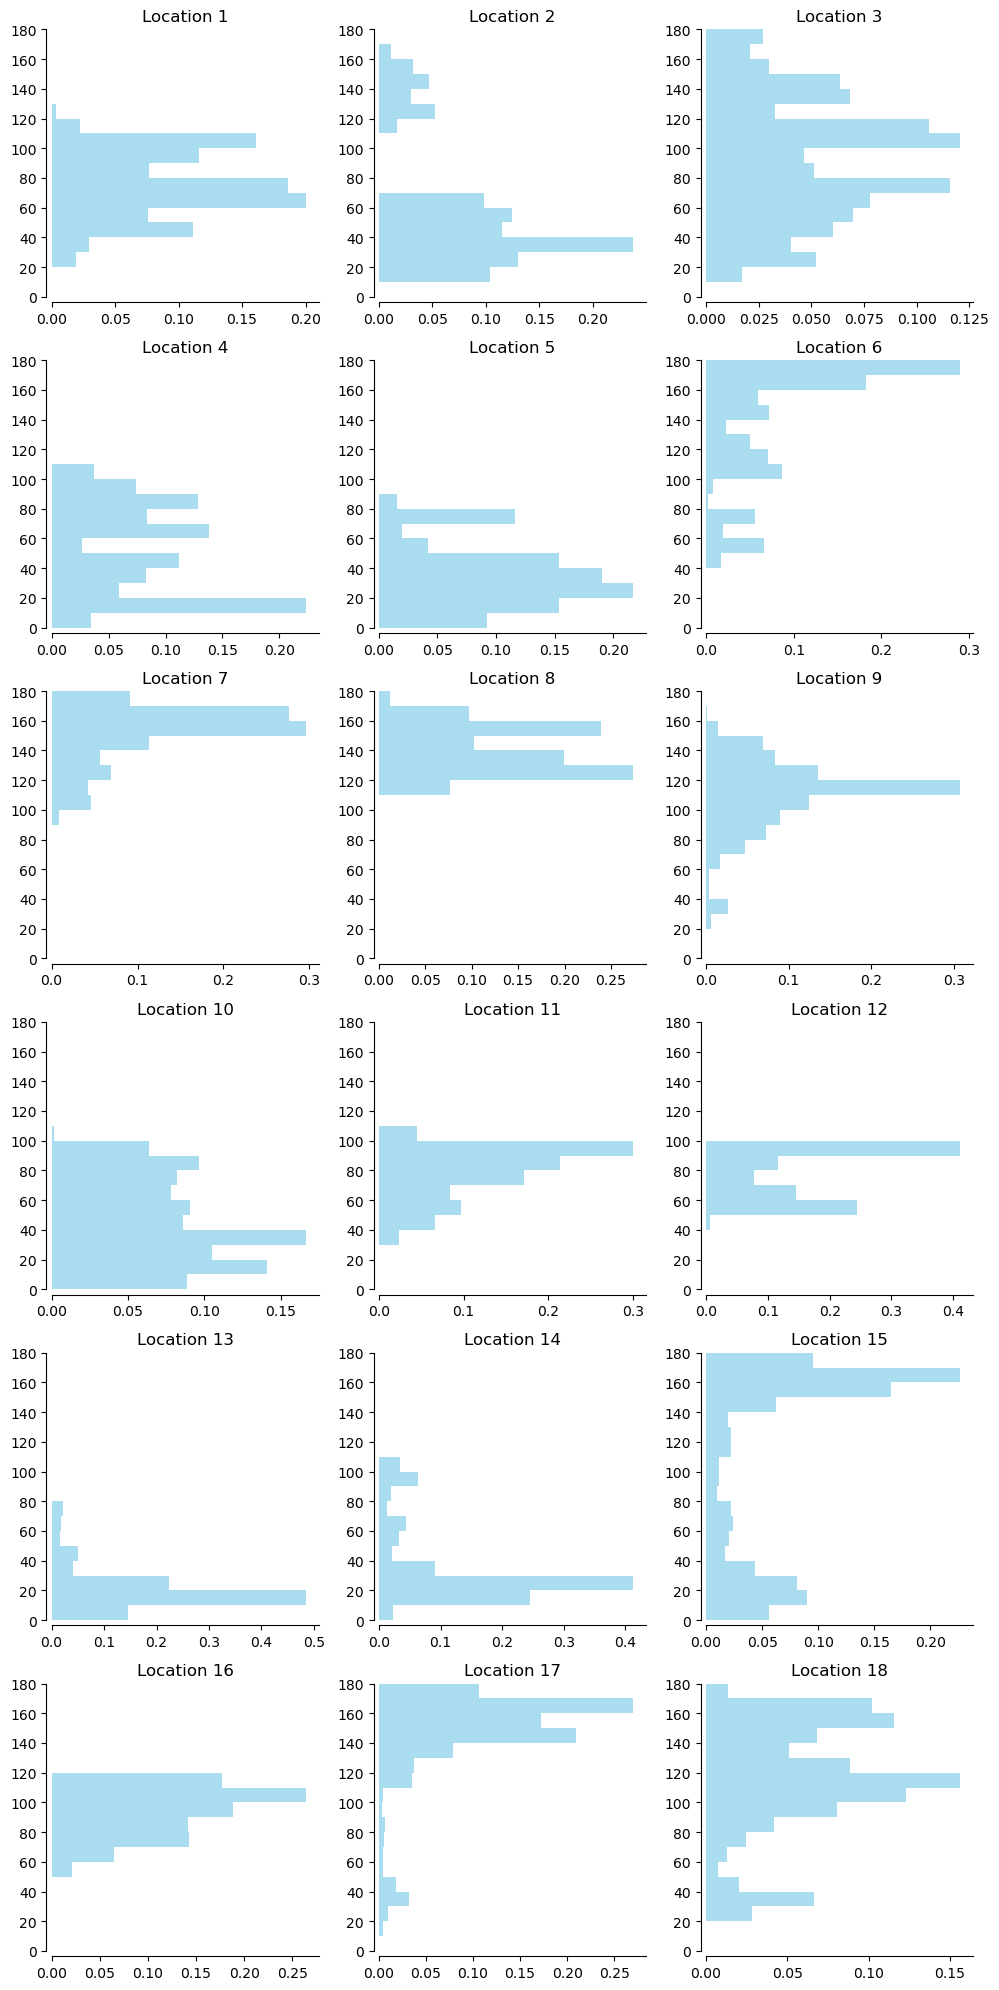

In [352]:
events = pd.read_csv(data_dir + '/events.csv')
bins = np.arange(0,181, 10)
bin_centers = (bins[:-1] + bins[1:]) / 2

fig_name = f'./figure/{sub_name}/gaze_angle_hist_{task_name}.png'
fig, ax = plt.subplots(6,3, figsize=(10,20))
ax = ax.flatten()
hist_ = []
for e in range(1, len(events)-2):
    # select the gazes within the event
    start = events['timestamp [ns]'].loc[e]
    end = events['timestamp [ns]'].loc[e+1]
    this_gaze = gaze_filtered.loc[(gaze_filtered['timestamp [ns]'] >= start) & (gaze_filtered['timestamp [ns]'] < end)]
    
    # generate a histogram
    counts, _ = np.histogram(this_gaze['gaze angle'], bins=bins)
    norm_counts = counts/np.sum(counts)
    hist_.append([norm_counts])
    
    # plot the histogram
    ax[e-1].barh(bin_centers, norm_counts, height=10, color='skyblue', alpha=0.7)
    ax[e-1].set_title(f'Location {e}')
    ax[e-1].set_ylim([0, 180])
    cf.xy_axis_format(ax[e-1])
fig.tight_layout()
fig.savefig(fig_name)

if not os.path.exists(f'./data/{sub_name}'):
    os.mkdir(f'./data/{sub_name}')
np.save(f'./data/{sub_name}/gaze_angle_{task_name}.npy', hist_)
    


### Compute cosine similarity matrix using the histogram

In [353]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

def compute_cosine_similarity_matrix(histograms):
    if isinstance(histograms[0], list):
        histograms = [h[0] for h in histograms]
    
    histograms = np.array(histograms)
    
    return cosine_similarity(histograms)


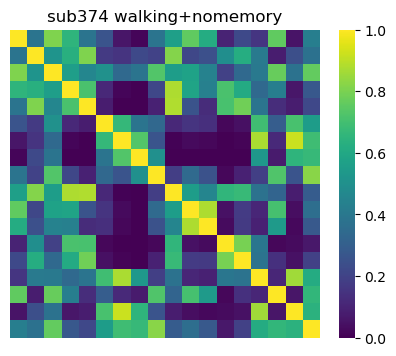

In [354]:
# compute cosine_similarity matrix
similarity_matrix = compute_cosine_similarity_matrix(hist_)
fig_name = f'./figure/{sub_name}/similarity_matrix_{task_name}.png'
# visualize 
plt.figure(figsize=(5,4))
sns.heatmap(similarity_matrix, cmap='viridis')
plt.xticks([])
plt.yticks([])
plt.title(f'{sub_name} {task_name}')
plt.savefig(fig_name)

